# AI EU Project #

In [13]:
import numpy as np
import pandas as pd

# Load the dataset
df = pd.read_excel('pstw_dataset.xlsx')

## Drop unnused columns ##

In [14]:
# Ensures all the projects are within AI 
df = df[df['Primary Technology'].str.lower() == 'artificial intelligence']

# Replaces Pilot phase with pilot for consistensy
df[' Status'] = df[' Status'].replace({'Pilot phase': 'Pilot'})

# This will be the hyperparameter used when modelling
df_y = df[' Status']

# Resets the indexing so that it will match the other data when modelling
df_y = df_y.reset_index(drop=True)

# All columns needed for the project
columns = [
    "Geographical extent",
    "Functions of Government (COFOG level I)",
    "Functions of Government (COFOG level II)",
    "Process type",
    "Application type",
    "Cross Border",
    "Cross Sector",
    "Interaction",
    "Increase quality of PSI and services",
    "Improved management of public resources",
    "Increased quality of processes and systems",
    "AI Classification (I)",
    "AI Classification Subdomain (II) (main)",
    "AI Classification Subdomain (II) (Other I)",
    "AI Keywords",
    "Collaboration type",
    "Funding source"
]

# Columns to replace that contains X:s
x_columns = [
    # "Improved Public Service",
    # "Personalized Services",
    # "Public (citizen)-centered services",
    "Increase quality of PSI and services",
    # "More responsive, efficient, and cost-effective public services",
    # "New services or channels",
    # "Improved Administrative Efficiency",
    # "Cost-reduction",
    # "Responsiveness of government operation",
    "Improved management of public resources",
    "Increased quality of processes and systems",
    # "Open government capabilities",
    # "Increased transparency of public sector operations"
]

# Selects the right columns
df_selected = df[columns]

# Replaces X/ x with 1 or 0 to ease dummy-encoding
def translate_x(dataFrame, column):
  dataFrame[column] = dataFrame[column].replace({
      "x": 1,
      "X": 1,
      "\xa0": 0,
      np.nan: 0
  })
  dataFrame[column] = dataFrame[column].astype(int)

# Translates X in for the right columns
for column in x_columns:
    translate_x(df_selected, column)

# Dummy encoding
df_oh = pd.get_dummies(df_selected, dtype=int)

# Resets the index so that it will match when modelling
df_oh = df_oh.reset_index(drop=True)

print(df_oh.info())
print(df_y.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1575 entries, 0 to 1574
Columns: 264 entries, Increase quality of PSI and services to Funding source_Regional-funded project
dtypes: int64(264)
memory usage: 3.2 MB
None
['Not in use' 'Implemented' 'Pilot' 'Planned' 'In development']


/tmp/ipykernel_795632/2116518268.py:56: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataFrame[column] = dataFrame[column].replace({
/tmp/ipykernel_795632/2116518268.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame[column] = dataFrame[column].replace({
/tmp/ipykernel_795632/2116518268.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

Index(['Increase quality of PSI and services',
       'Improved management of public resources',
       'Increased quality of processes and systems',
       'Geographical extent_Across Countries',
       'Geographical extent_Across countries', 'Geographical extent_Local',
       'Geographical extent_National', 'Geographical extent_National ',
       'Geographical extent_Regional', 'Geographical extent_Regional ',
       ...
       'Collaboration type_Other PAs',
       'Collaboration type_Private corporation',
       'Collaboration type_Sandboxing', 'Collaboration type_Universities',
       'Collaboration type_Universities/Research organisations',
       'Funding source_EU-funded project',
       'Funding source_Funded with own resources',
       'Funding source_Local-funded project',
       'Funding source_National-funded project',
       'Funding source_Regional-funded project'],
      dtype='object', length=264)
[1.65580091e-02 1.68355150e-02 1.78018720e-02 1.40114280e-02
 8.1577793

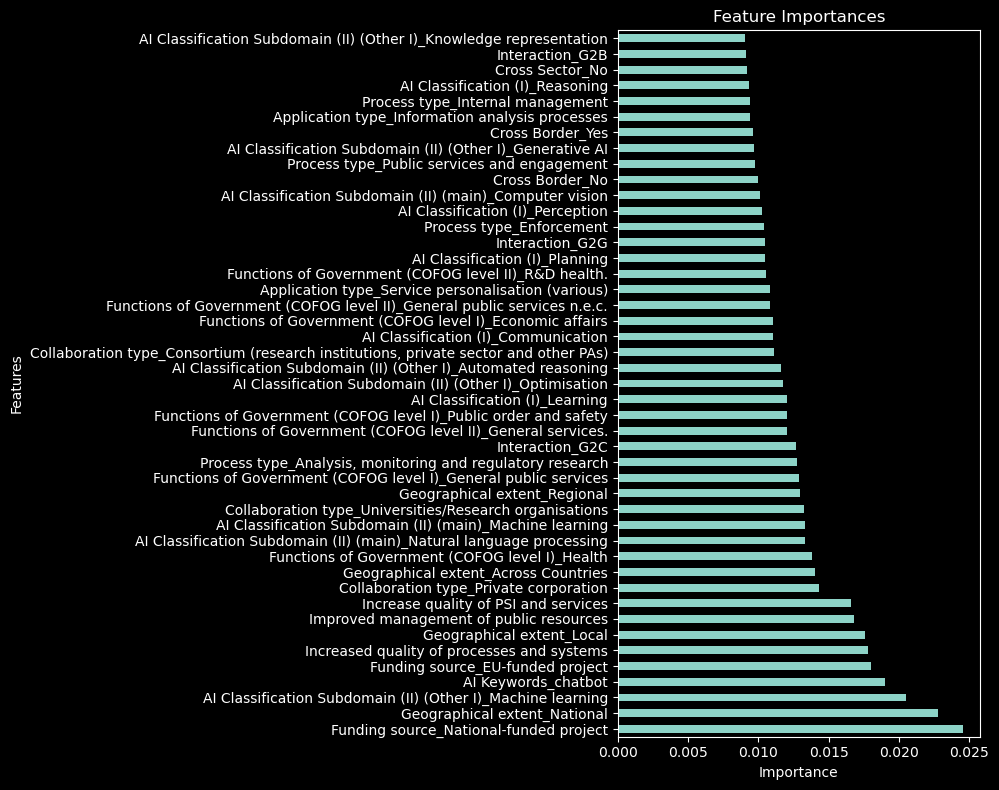

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X = df_oh
y = df_y

# Split data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=42, test_size=0.2)

rm_model = RandomForestClassifier()

rm_model.fit(X_train, y_train)


importances = rm_model.feature_importances_
feature_names = X.columns

print(feature_names)
feat_df = pd.DataFrame({
  'Feature': feature_names,
  'Importance': importances
})

filtered_df = feat_df[feat_df['Importance'] > 0.009]

filtered_df = filtered_df.sort_values(by='Importance', ascending=False)

print(importances)

filtered_df.plot(
    kind='barh',
    x='Feature',
    y='Importance',
    legend=False,
    figsize=(10, 8)
)

plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

plt.tight_layout()
plt.show()

plt.show() 